In [129]:
!pip install docplex cplex

In [130]:
#Importing cplex API
import sys
import cplex
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

#Imports
from enum import Enum
from cplex.callbacks import UserCutCallback, LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
import networkx as nx

**Definizione classi**

Classe lazy constraints

In [131]:
class LazyCallback(ConstraintCallbackMixin, LazyConstraintCallback):
  def __init__(self, env):
    LazyConstraintCallback.__init__(self, env)
    ConstraintCallbackMixin.__init__(self)

  def __call__(self):
    try:
      # Controlliamo tutti i cicli maggiori di k
      for c in self.C:
        # Salviamo la soluzione trovata senza l'uso di lazy constraints
        y_sol = self.make_complete_solution().get_value_dict(self.y)
        # Controlliamo se il ciclo fa parte della soluzione trovata
        served = sum([y_sol[e] for e in c])

        if not (served <= (len(c) - 1)):
          print('Adding lazy constraint %s <= %d' % 
                (' + '.join(['y(%d)' % (x) for x in c]), len(c) - 1))
          # Aggiungiamo la matrice con il vincolo relativo al ciclo nel modello
          self.add(constraint=cplex.SparsePair(ind=[x for x in c],
                                               val=[y_sol[e] for e in c]), 
                  sense='L', 
                  rhs=(len(c) - 1))
          
    except:
      print(sys.exc_info()[0])
      raise

Classe vertice

In [132]:
class Type(Enum):
  AD = 1
  B = 2
  P = 3


class Vertex:
  def __init__(self, tp, delta_in, delta_out):
    self.tp = tp

    # delta_in = minus
    self.delta_in = delta_in
    
    # delta_out = plus
    self.delta_out = delta_out

**Definizione funzioni**

In [133]:
def get_cycles_edges(C, V):
  edges = []
  aux = []

  for c in C:
    aux = []
    
    for i,_ in enumerate(c):
      if (i + 1) != len(c):
        aux.append(list(set(V[c[i]].delta_out).intersection(set(V[c[i + 1]].delta_in)))[0])
      
      else:
        aux.append(list(set(V[c[i]].delta_out).intersection(set(V[c[0]].delta_in)))[0])
    
    edges.append(aux)

  return edges

In [134]:
# Example's choice
flag = 3
lazy = False

**Esempio 1**

In [135]:
if flag == 1:
  E = [i for i in range(0, 8)]    # Edges
  V = []  # Vertex
  w = [1 for i in range(0, 8)]  # Weigths
  k = 3

In [136]:
if flag == 1:
  V.append(Vertex(tp=Type.AD, delta_in=[], delta_out=[0]))    # 0
  V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1]))    # 1
  V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2, 3])) # 2
  V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[4]))    # 3
  V.append(Vertex(tp=Type.P, delta_in=[3, 5], delta_out=[6])) # 4
  V.append(Vertex(tp=Type.P, delta_in=[6], delta_out=[5, 7])) # 5
  V.append(Vertex(tp=Type.P, delta_in=[4], delta_out=[]))     # 6
  V.append(Vertex(tp=Type.P, delta_in=[7], delta_out=[]))     # 7

Stampa grafo

In [137]:
if flag == 1:
  G = nx.DiGraph()
  G.add_edges_from([(0, 1), (1, 2), (2, 3), (2, 4), (3, 6), 
                    (4, 5), (5, 4), (5, 7)])

  
  pos = {0: (0, 1),
         1: (1, 1),
         2: (2, 1),
         3: (3, 1),
         4: (0, 2),
         5: (1, 2),
         6: (2, 2),
         7: (3, 2)}
  plt.figure(figsize =(12, 6))
  plt.title("Grafo iniziale", fontsize=25)

  nx.draw_networkx(G, pos=pos, with_labels=True, node_color='yellow', node_size=1000, 
                  font_size=16, arrowstyle="->", width=2)

**Esempio 2**

In [138]:
if flag == 2:
  E = [i for i in range(0, 13)]    # Edges
  V = []  # Vertex
  w = [1 for i in range(0, 13)]  # Weigths
  k = 3

In [139]:
if flag == 2:
  V.append(Vertex(tp=Type.P, delta_in=[6, 4, 12], delta_out=[0])) # 0
  V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1]))        # 1
  V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2, 12]))    # 2
  V.append(Vertex(tp=Type.P, delta_in=[5], delta_out=[6, 7]))     # 3
  V.append(Vertex(tp=Type.P, delta_in=[3], delta_out=[4, 5, 9]))  # 4
  V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[3, 8]))     # 5
  V.append(Vertex(tp=Type.P, delta_in=[7], delta_out=[]))         # 6
  V.append(Vertex(tp=Type.P, delta_in=[9], delta_out=[]))         # 7
  V.append(Vertex(tp=Type.P, delta_in=[8, 11], delta_out=[10]))   # 8
  V.append(Vertex(tp=Type.P, delta_in=[10], delta_out=[11]))      # 9

Stampa grafo

In [140]:
if flag == 2:
  G = nx.DiGraph()
  G.add_edges_from([(0, 1), (1, 2), (2, 5), (5, 4), (4, 0), (4, 3), (3, 0), 
                    (3, 6), (5, 8), (4, 7), (8, 9), (9, 8), (2, 0)])

  pos = {0: (0, 1),
         1: (1, 1),
         2: (2, 1),
         3: (3, 1),
         4: (4, 1),
         5: (0, 2),
         6: (1, 2),
         7: (2, 2),
         8: (3, 2),
         9: (4, 2)}
  plt.figure(figsize =(12, 6))
  plt.title("Grafo iniziale", fontsize=25)

  nx.draw_networkx(G, pos=pos, with_labels = True, node_color ='yellow', node_size = 1000, 
                  font_size = 16, arrowstyle="->", width=2)

**Esempio 3**

In [141]:
if flag == 3:
  E = [i for i in range(0, 18)]    # Edges
  V = []  # Vertex
  w = [1 for i in range(0, 18)]  # Weigths
  k = 3

In [142]:
if flag == 3:
  V.append(Vertex(tp=Type.AD, delta_in=[], delta_out=[0]))        # 0
  V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1, 5]))     # 1
  V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2]))        # 2
  V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[3, 13]))    # 3
  V.append(Vertex(tp=Type.P, delta_in=[3], delta_out=[4]))        # 4
  V.append(Vertex(tp=Type.P, delta_in=[4], delta_out=[]))         # 5
  V.append(Vertex(tp=Type.P, delta_in=[7], delta_out=[6]))        # 6
  V.append(Vertex(tp=Type.P, delta_in=[6], delta_out=[9]))        # 7
  V.append(Vertex(tp=Type.P, delta_in=[10], delta_out=[11]))      # 8
  V.append(Vertex(tp=Type.P, delta_in=[13], delta_out=[12, 16]))  # 9
  V.append(Vertex(tp=Type.P, delta_in=[16], delta_out=[14]))      # 10
  V.append(Vertex(tp=Type.AD, delta_in=[], delta_out=[15]))       # 11
  V.append(Vertex(tp=Type.P, delta_in=[8], delta_out=[7]))        # 12
  V.append(Vertex(tp=Type.P, delta_in=[9], delta_out=[8]))        # 13
  V.append(Vertex(tp=Type.P, delta_in=[11], delta_out=[10]))      # 14
  V.append(Vertex(tp=Type.P, delta_in=[12], delta_out=[]))        # 15
  V.append(Vertex(tp=Type.P, delta_in=[14], delta_out=[17]))      # 16
  V.append(Vertex(tp=Type.P, delta_in=[15, 17], delta_out=[]))    # 17

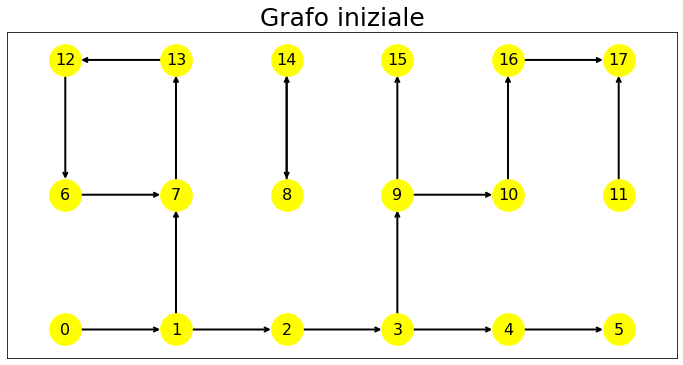

In [154]:
if flag == 3:
  G = nx.DiGraph()
  G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (1, 7), (6, 7), (7, 13), 
                    (13, 12), (12, 6), (8, 14), (14, 8), (3, 9), (9, 15), (9, 10), 
                    (10, 16), (16, 17), (11, 17)])

  pos = {0: (0, 1),
         1: (1, 1),
         2: (2, 1),
         3: (3, 1),
         4: (4, 1),
         5: (5, 1),
         6: (0, 2),
         7: (1, 2),
         8: (2, 2),
         9: (3, 2),
         10: (4, 2),
         11: (5, 2),
         12: (0, 3),
         13: (1, 3),
         14: (2, 3),
         15: (3, 3),
         16: (4, 3),
         17: (5, 3)}
  plt.figure(figsize =(12, 6))
  plt.title("Grafo iniziale", fontsize=25)

  nx.draw_networkx(G, pos=pos, with_labels = True, node_color ='yellow', node_size = 1000, 
                  font_size = 16, arrowstyle="->", width=2)

**Definizione modello**

In [144]:
# Model
model = Model('KEP_model')

# Decision variables
y = model.binary_var_dict(E, name='y')
f_in = model.continuous_var_dict(len(V), name='f_in')
f_out = model.continuous_var_dict(len(V), name='f_out')

In [145]:
#Function to maximize
model.maximize(model.sum((w[e] * y[e]) for e in E))

In [146]:
#Constraints
model.add_constraints(model.sum(y[e] for e in V[v].delta_in) == f_in[v] for v,_ in enumerate(V))
model.add_constraints(model.sum(y[e] for e in V[v].delta_out) == f_out[v] for v,_ in enumerate(V))
model.add_constraints((f_out[v] <= f_in[v]) for v,_ in enumerate(V) if V[v].tp == Type.P)
model.add_constraints((f_in[v] <= 1) for v,_ in enumerate(V) if V[v].tp == Type.P)
model.add_constraints((f_out[v] <= 1) for v,_ in enumerate(V) if (V[v].tp == Type.AD or V[v].tp == Type.B))

[docplex.mp.LinearConstraint[](f_out_0,LE,1),
 docplex.mp.LinearConstraint[](f_out_11,LE,1)]

In [147]:
if lazy:
  all_cycles = list(nx.simple_cycles(G))
  C = []

  # Creiamo una lista di tutti i cicli con una lunghezza maggiore di k
  for c in all_cycles:
    if len(c) > k:
      C.append(c)

  C_edges = get_cycles_edges(C, V)

  if len(C) > 0:
    # Aggiungiamo il lazy constraints al modello
    clb = model.register_callback(LazyCallback)
    clb.C = C_edges
    clb.y = y

**Risoluzione modello**

In [148]:
solution = model.solve(log_output=True)
model.solve(log_output=True)

Version identifier: 20.1.0.1 | 2021-12-07 | 9dfdf6686
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 4 times.
MIP Presolve eliminated 36 rows and 20 columns.
MIP Presolve added 3 rows and 3 columns.
Aggregator did 37 substitutions.
All rows and columns eliminated.
Presolve time = 0.01 sec. (0.11 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.11 ticks)
Parallel b&c, 2 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.11 ticks)
Version identifier: 20.1.0.1 | 2021-12-07 | 9dfdf6686
CPXPARAM_Read_DataCheck                          1

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 2 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync t

docplex.mp.solution.SolveSolution(obj=13,values={y_0:1,y_1:1,y_2:1,y_6:1..

**Stampa soluzione**

Soluzione

In [149]:
print(solution)

solution for: KEP_model
objective: 13
y_0=1
y_1=1
y_2=1
y_6=1
y_7=1
y_8=1
y_9=1
y_10=1
y_11=1
y_13=1
y_14=1
y_15=1
y_16=1
f_in_1=1.000
f_in_2=1.000
f_in_3=1.000
f_in_6=1.000
f_in_7=1.000
f_in_8=1.000
f_in_9=1.000
f_in_10=1.000
f_in_12=1.000
f_in_13=1.000
f_in_14=1.000
f_in_16=1.000
f_in_17=1.000
f_out_0=1.000
f_out_1=1.000
f_out_2=1.000
f_out_3=1.000
f_out_6=1.000
f_out_7=1.000
f_out_8=1.000
f_out_9=1.000
f_out_10=1.000
f_out_11=1.000
f_out_12=1.000
f_out_13=1.000
f_out_14=1.000



Grafo finale

In [150]:
temp = [(u, v) for u,v,i in G.edges(data=True) if (solution.get_value_dict(f_out)[u] == 1) and (solution.get_value_dict(f_in)[v] == 1)]

res = []
for u,v in temp:
  edge = list(set(V[u].delta_out).intersection(set(V[v].delta_in)))
  if len(edge) > 0:
    if solution.get_value_dict(y)[edge[0]] == 1.0:
      res.append((u, v))

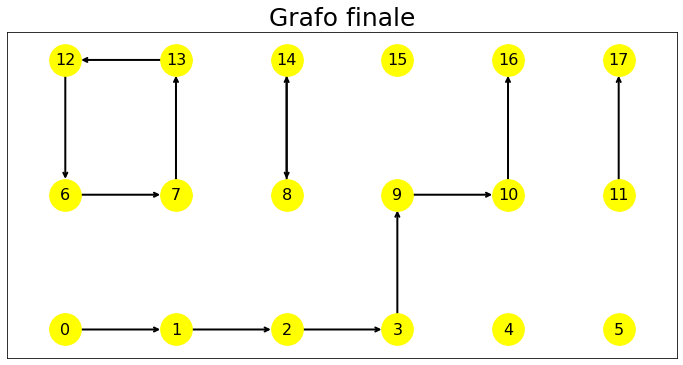

In [153]:
plt.figure(figsize =(12, 6))
plt.title("Grafo finale", fontsize=25)

nx.draw_networkx(G, pos=pos, with_labels=True, node_color='yellow', node_size=1000, 
                 font_size=16, edgelist=res, arrowstyle="->", width=2)